# Topic Modelling

In [438]:
import os
import re
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from glob import glob
from tqdm.notebook import tqdm
import xml.etree.ElementTree as ET
from multiprocessing import Pool
import matplotlib.pyplot as plt


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import gensim
import gensim.corpora as corpora
import pyLDAvis
from pyLDAvis import gensim_models
# import pyLDAvis.gensim
from textacy.tm import TopicModel
import guidedlda
from guidedlda import GuidedLDA
from sklearn.decomposition import LatentDirichletAllocation

# Visualize the topics
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /Users/syip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load dataset

In [3]:
file_list = glob('blogs/*')
print(f"Total file count: {len(file_list)}")
file_list[:5]

Total file count: 19320


['blogs/4162441.male.16.Student.Sagittarius.xml',
 'blogs/3489929.female.25.Student.Cancer.xml',
 'blogs/3954575.female.23.BusinessServices.Gemini.xml',
 'blogs/3364931.male.16.Student.Virgo.xml',
 'blogs/3162067.female.24.Education.Cancer.xml']

In [4]:
def extractTextFromElement(elementName, xml_file):
    stringofxml = open(xml_file).read()
    text = ''
    tree = ET.fromstring(stringofxml)
    for child in tree:
        if child.tag == elementName:
            text += child.text.strip()
    return text

print(extractTextFromElement(elementName='post', xml_file=file_list[0]))

DESTINY...       you might not say anything     but i can hear     you have chosen me, your life partner     so have i dear,     so have i dear....      my first dream, my first extreme,     my first love, i was waiting for my DESTINY.     what should i do with myself,     tell me o' my heart     what should i do with myself,     tell me....      should i fly, with this beautiful nature.     or should i play with these winds.     should i try to reach the skies,     or should i pray to the mother earth.     what should i do with myself friends     tell me....      she talked in such a way,     gave me dreams with thousand colours.     like i stand in the middle of island,     and she shows me all the love she has,     my first dream , my first extreme,     my first love, i was waiting for my DESTINY.           --NILDEAR ANGEL..      you say it or you don't,     but i can see it in your eyes,     some words are not worth saying,     they try to remain in your heart.     i saw it years a

In [296]:
# dct = {idx:extractTextFromElement('post',file) for idx, file in enumerate(file_list[:600])}
# lst = [extractTextFromElement('post',file) for file in file_list[400:600]]

lst=[]
for file in tqdm(file_list[3200:4000]):
    try:
        res = extractTextFromElement('post',file)
        lst.append(res)
    except Exception:
        continue
print(f"Loaded {len(lst)} files. ")

  0%|          | 0/800 [00:00<?, ?it/s]

Loaded 327 files. 


## Exploratory - word cloud

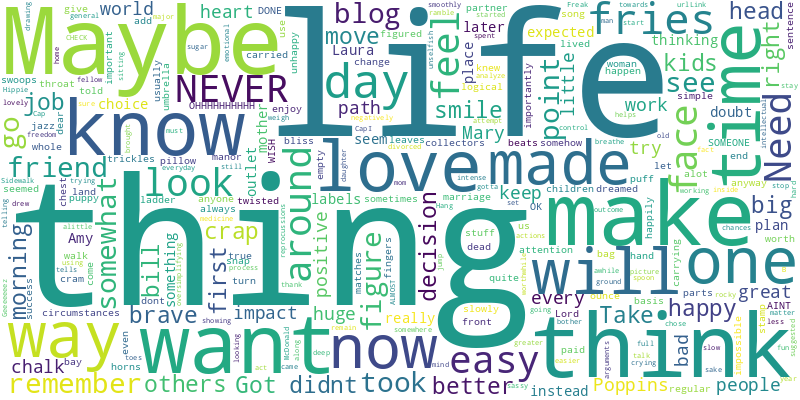

In [297]:
wordcloud = WordCloud(background_color="white", max_words=5000,
                      contour_width=3, contour_color='steelblue',
                      width=800, height=400)

# Generate a word cloud
wordcloud.generate(lst[0])

# Visualize the word cloud
wordcloud.to_image()

## Data Prep
### Stopwords

In [467]:
custom_stop_words = set(stopwords.words("english")).union({
       'a', 'able', 'about', 'above', 'abst', 'accordance',
       'according', 'accordingly', 'across', 'act', 'actually', 'added',
       'adj', 'affected', 'affecting', 'affects', 'after', 'afterwards',
       'again', 'against', 'ah', 'all', 'almost', 'alone', 'along',
       'already', 'also', 'although', 'always', 'am', 'among', 'amongst',
       'an', 'and', 'announce', 'another', 'any', 'anybody', 'anyhow',
       'anymore', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere',
       'apparently', 'approximately', 'are', 'aren', 'arent', 'arise',
       'around', 'as', 'aside', 'ask', 'asking', 'at', 'auth',
       'available', 'away', 'awfully', 'b', 'back', 'be', 'became',
       'because', 'become', 'becomes', 'becoming', 'been', 'before',
       'beforehand', 'begin', 'beginning', 'beginnings', 'begins',
       'behind', 'being', 'believe', 'below', 'beside', 'besides',
       'between', 'beyond', 'biol', 'both', 'brief', 'briefly', 'but',
       'by', 'c', 'ca', 'came', 'can', 'cannot', "can't", 'cause',
       'causes', 'certain', 'certainly', 'co', 'com', 'come', 'comes',
       'contain', 'containing', 'contains', 'could', 'couldnt', 'd',
       'date', 'did', "didn't", 'different', 'do', 'does', "doesn't",
       'doing', 'done', "don't", 'down', 'downwards', 'due', 'during',
       'e', 'each', 'ed', 'edu', 'effect', 'eg', 'eight', 'eighty',
       'either', 'else', 'elsewhere', 'end', 'ending', 'enough',
       'especially', 'et', 'et-al', 'etc', 'even', 'ever', 'every',
       'everybody', 'everyone', 'everything', 'everywhere', 'ex',
       'except', 'f', 'far', 'few', 'ff', 'fifth', 'first', 'five', 'fix',
       'followed', 'following', 'follows', 'for', 'former', 'formerly',
       'forth', 'found', 'four', 'from', 'further', 'furthermore', 'g',
       'gave', 'get', 'gets', 'getting', 'give', 'given', 'gives',
       'giving', 'go', 'goes', 'going', 'gone', 'got', 'gotten', 'h',
       'had', 'happens', 'hardly', 'has', "hasn't", 'have', "haven't",
       'having', 'he', 'hed', 'hence', 'her', 'here', 'hereafter',
       'hereby', 'herein', 'heres', 'hereupon', 'hers', 'herself', 'hes',
       'hi', 'hid', 'him', 'himself', 'his', 'hither', 'home', 'how',
       'howbeit', 'however', 'hundred', 'i', 'id', 'ie', 'if', "i'll",
       'im', 'immediate', 'immediately', 'importance', 'important', 'in',
       'inc', 'indeed', 'index', 'information', 'instead', 'into',
       'invention', 'inward', 'is', "isn't", 'it', 'itd', "it'll", 'its',
       'itself', "i've", 'j', 'just', 'k', 'keep', 'keeps', 'kept', 'kg',
       'km', 'know', 'known', 'knows', 'l', 'largely', 'last', 'lately',
       'later', 'latter', 'latterly', 'least', 'less', 'lest', 'let',
       'lets', 'like', 'liked', 'likely', 'line', 'little', "'ll", 'look',
       'looking', 'looks', 'ltd', 'm', 'made', 'mainly', 'make', 'makes',
       'many', 'may', 'maybe', 'me', 'mean', 'means', 'meantime',
       'meanwhile', 'merely', 'mg', 'might', 'million', 'miss', 'ml',
       'more', 'moreover', 'most', 'mostly', 'mr', 'mrs', 'much', 'mug',
       'must', 'my', 'myself', 'n', 'na', 'name', 'namely', 'nay', 'nd',
       'near', 'nearly', 'necessarily', 'necessary', 'need', 'needs',
       'neither', 'never', 'nevertheless', 'new', 'next', 'nine',
       'ninety', 'no', 'nobody', 'non', 'none', 'nonetheless', 'noone',
       'nor', 'normally', 'nos', 'not', 'noted', 'nothing', 'now',
       'nowhere', 'o', 'obtain', 'obtained', 'obviously', 'of', 'off',
       'often', 'oh', 'ok', 'okay', 'old', 'omitted', 'on', 'once', 'one',
       'ones', 'only', 'onto', 'or', 'ord', 'other', 'others',
       'otherwise', 'ought', 'our', 'ours', 'ourselves', 'out', 'outside',
       'over', 'overall', 'owing', 'own', 'p', 'page', 'pages', 'part',
       'particular', 'particularly', 'past', 'per', 'perhaps', 'placed',
       'please', 'plus', 'poorly', 'possible', 'possibly', 'potentially',
       'pp', 'predominantly', 'present', 'previously', 'primarily',
       'probably', 'promptly', 'proud', 'provides', 'put', 'q', 'que',
       'quickly', 'quite', 'qv', 'r', 'ran', 'rather', 'rd', 're',
       'readily', 'really', 'recent', 'recently', 'ref', 'refs',
       'regarding', 'regardless', 'regards', 'related', 'relatively',
       'research', 'respectively', 'resulted', 'resulting', 'results',
       'right', 'run', 's', 'said', 'same', 'saw', 'say', 'saying',
       'says', 'sec', 'section', 'see', 'seeing', 'seem', 'seemed',
       'seeming', 'seems', 'seen', 'self', 'selves', 'sent', 'seven',
       'several', 'shall', 'she', 'shed', "she'll", 'shes', 'should',
       "shouldn't", 'show', 'showed', 'shown', 'showns', 'shows',
       'significant', 'significantly', 'similar', 'similarly', 'since',
       'six', 'slightly', 'so', 'some', 'somebody', 'somehow', 'someone',
       'somethan', 'something', 'sometime', 'sometimes', 'somewhat',
       'somewhere', 'soon', 'sorry', 'specifically', 'specified',
       'specify', 'specifying', 'still', 'stop', 'strongly', 'sub',
       'substantially', 'successfully', 'such', 'sufficiently', 'suggest',
       'sup', 'sure\tt', 'take', 'taken', 'taking', 'tell', 'tends', 'th',
       'than', 'thank', 'thanks', 'thanx', 'that', "that'll", 'thats',
       "that've", 'the', 'their', 'theirs', 'them', 'themselves', 'then',
       'thence', 'there', 'thereafter', 'thereby', 'thered', 'therefore',
       'therein', "there'll", 'thereof', 'therere', 'theres', 'thereto',
       'thereupon', "there've", 'these', 'they', 'theyd', "they'll",
       'theyre', "they've", 'think', 'this', 'those', 'thou', 'though',
       'thoughh', 'thousand', 'throug', 'through', 'throughout', 'thru',
       'thus', 'til', 'tip', 'to', 'together', 'too', 'took', 'toward',
       'towards', 'tried', 'tries', 'truly', 'try', 'trying', 'ts',
       'twice', 'two', 'u', 'un', 'under', 'unfortunately', 'unless',
       'unlike', 'unlikely', 'until', 'unto', 'up', 'upon', 'ups', 'urllink', 'us',
       'use', 'used', 'useful', 'usefully', 'usefulness', 'uses', 'using',
       'usually', 'v', 'value', 'various', "'ve", 'very', 'via', 'viz',
       'vol', 'vols', 'vs', 'w', 'want', 'wants', 'was', 'wasnt', 'way',
       'we', 'wed', 'welcome', "we'll", 'went', 'were', 'werent', "we've",
       'what', 'whatever', "what'll", 'whats', 'when', 'whence',
       'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein',
       'wheres', 'whereupon', 'wherever', 'whether', 'which', 'while',
       'whim', 'whither', 'who', 'whod', 'whoever', 'whole', "who'll",
       'whom', 'whomever', 'whos', 'whose', 'why', 'widely', 'willing',
       'wish', 'with', 'within', 'without', 'wont', 'words', 'world',
       'would', 'wouldnt', 'www', 'x', 'y', 'yes', 'yet', 'you', 'youd',
       "you'll", 'your', 'youre', 'yours', 'yourself', 'yourselves',
       "you've", 'z', 'zero'
})

### UDFs

In [299]:
def remove_stopwords(tokens):
    tokens_without_sw = [word for word in tokens if word not in custom_stop_words]
    return tokens_without_sw

def remove_punctuation(string, sub=' '):
#     tokens_without_punc = [word for word in tokens if word not in [',','!','?','.','^','/']]
    string_without_punc = re.sub('[,\.!?:;`^]', sub, string)
    return string_without_punc

def remove_numbers(string, sub=''):
    string_without_numb = re.sub('\d*', sub, string)
    return string_without_numb

def process_text(text_string, rm_stopwords=True, rm_punctuation=True, rm_numbers=True):
    if rm_punctuation:
        text_string = remove_punctuation(string=text_string)
    if rm_numbers:
        text_string = remove_numbers(string=text_string)
        
    text_tokens = word_tokenize(text_string)
    if rm_stopwords:
        text_tokens = remove_stopwords(tokens=text_tokens)

    return " ".join(text_tokens)
    

In [300]:
lst_cleaned = [process_text(doc, 
                            rm_stopwords=True, 
                            rm_numbers=True,
                            rm_punctuation=True,
                           ) for doc in tqdm(lst)]

# with Pool(4) as p:
#     lst_cleaned = list(tqdm(p.imap(process_text, lst[:20])))

  0%|          | 0/327 [00:00<?, ?it/s]

## Training 
### with Gensim & pyLDAvis

In [301]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [302]:
tokens = list(sent_to_words(lst_cleaned))

In [303]:
# Create Dictionary
id2word = corpora.Dictionary(tokens)

# Term Document Frequency
corpus = [id2word.doc2bow(token) for token in tokens]


In [304]:
n_topics = 10
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=n_topics)

In [305]:
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model,
                                                 corpus,
                                                 id2word)


In [306]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.003653 -0.006353       1        1  23.508274
4      0.002252 -0.003328       2        1  16.955898
0      0.008723 -0.001073       3        1  11.802301
9     -0.003433 -0.004168       4        1  10.870667
8     -0.003046 -0.000486       5        1   8.838465
7     -0.000414  0.002801       6        1   7.706870
2      0.005138  0.001719       7        1   5.975371
1      0.001264  0.001040       8        1   5.877582
5     -0.001734  0.005668       9        1   4.716129
6     -0.005097  0.004180      10        1   3.748441, topic_info=       Term         Freq        Total Category  logprob  loglift
226     the  1909.000000  1909.000000  Default  30.0000  30.0000
118      it  1583.000000  1583.000000  Default  29.0000  29.0000
425    well  1248.000000  1248.000000  Default  28.0000  28.0000
52      day  1036.000000  1036.000000  Default  27.0000  27.0000
172  people  1379.000000  1379.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
230  things    22.313578   888.538018  Topic10  -6.0592  -0.4006
30      but    21.935789   944.054742  Topic10  -6.0763  -0.4782
138    love    21.581442   955.336679  Topic10  -6.0926  -0.5064
229   thing    18.801790   628.311537  Topic10  -6.2305  -0.2253
836      my    17.913808   569.308258  Topic10  -6.2788  -0.1750

[808 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
4774       2  0.538377        abotu
4776       1  0.353343   adequately
4776       2  0.353343   adequately
16977      1  0.309088    adherents
16977      2  0.309088    adherents
...      ...       ...          ...
1061       8  0.103259         your
1061       9  0.055072         your
1061      10  0.034420         your
10676      5  0.555862  yourcomment
17028      6  0.420265          zer

[2224 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 10, 9, 8, 3, 2, 6, 7])

### with Textacy & GuildedLDA

#### Vectorization

**CountVecterizer**  

Assigning weights by counting the occurence of words. Heavier weight is given to words with more frequent occurence.  

<br>


**TF-IDF Vectorerizer**

TF-IDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.  
  
A word vector represents a document as a list of numbers, with one for each possible word of the corpus. Vectorizing a document is taking the text and creating one of these vectors, and the numbers of the vectors somehow represent the content of the text. TF-IDF enables us to gives us a way to associate each word in a document with a number that represents how relevant each word is in that document. Then, documents with similar, relevant words will have similar vectors, which is what we are looking for in a machine learning algorithm.  


In [578]:
params = {
    'decode_error': 'ignore', 
    'ngram_range': (1, 3), 
    'analyzer': 'word',
    'max_features': 2000,
    'stop_words': custom_stop_words,
    'token_pattern': r'\b[^\d\W]{3,}\b',
    'use_idf': False,
    'norm': None
}


tfidf = TfidfVectorizer(**params)

In [579]:
lst_tokenised = tfidf.fit_transform(lst_cleaned) #.astype(int)
lst_tokenised

<327x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 2459 stored elements in Compressed Sparse Row format>

In [580]:
len(lst_cleaned)

327

In [581]:
# lst_tokenised_int =  tfidf.fit_transform(lst_cleaned).astype(int)
# lst_tokenised_int

In [582]:
id2word = {v: k for k, v in tfidf.vocabulary_.items()}
id2word

{1750: 'things things things',
 550: 'fell love time',
 1944: 'well work morning',
 1907: 'weapons mass destruction',
 849: 'harry potter movie',
 1927: 'well hope helps',
 1080: 'making music money',
 879: 'highland brewing company',
 1854: 'voice young america',
 1387: 'repeat dunno mani',
 492: 'dunno mani times',
 960: 'juz wan sae',
 132: 'blah blah blah',
 1300: 'post blog start',
 1545: 'short period time',
 1324: 'president george bush',
 916: 'house friday night',
 1974: 'work full time',
 1674: 'support gay marriage',
 1328: 'pretty good weekend',
 1000: 'kingdom god imagine',
 795: 'god opposes grace',
 1793: 'top ten things',
 1707: 'swimming pool small',
 1051: 'life spending time',
 301: 'christian high school',
 866: 'high school college',
 539: 'feel free comment',
 1213: 'pain ends die',
 789: 'god created live',
 1768: 'today good day',
 575: 'file ftp server',
 1433: 'response setheader content',
 240: 'cable internet access',
 246: 'call cable company',
 239: 'cable

#### Model Selection
**Point 1**  
For LDA, you need to specify in advance the number of topics (**k**) in the underlying topic structure.  

<br>

**Point 2**  
In general, perplexity is a measurement of how well a probability model predicts a sample. In the context of Natural Language Processing, perplexity is one way to evaluate language models.

In [476]:
n_topics = 10

lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=10, 
        learning_method='online', 
        learning_offset=2
    )

In [478]:
lda.fit(lst_tokenised)
lda_out = lda.transform(lst_tokenised)

In [480]:
lda.perplexity(lst_tokenised)

1775.4204115809148

Use perplexity to evaluate models by comparing perplexity across different models with varying **k**'s. The model with the lowest perplexity is generally considered the “best”.

  0%|          | 0/18 [00:00<?, ?it/s]

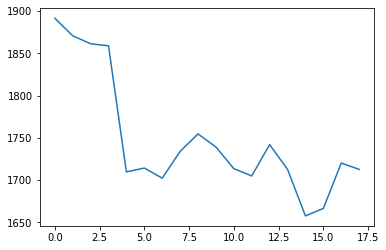

In [481]:
perplexity = []
for n_topics in tqdm(range(2, 20)):
    lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=10, 
        learning_method='online', 
        learning_offset=2
    )
    lda.fit(lst_tokenised)
    lda_out = lda.transform(lst_tokenised)
    perplexity.append(lda.perplexity(lst_tokenised))
plt.plot(perplexity)

#### Determine No. of Topics

In [482]:
n_topics = 8

lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=10, 
        learning_method='online', 
        learning_offset=2,
        random_state=1
    )
lda.fit(lst_tokenised)
lda_out = lda.transform(lst_tokenised)

<AxesSubplot:>

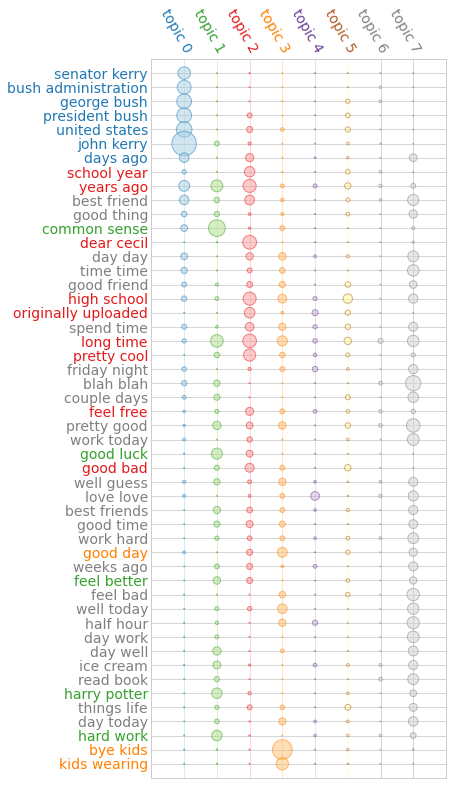

In [483]:
tm = TopicModel(lda, n_topics=n_topics)
tm.termite_plot(
    doc_term_matrix=tm.model.components_, 
    id2term=id2word, 
    topics=-1,
    n_terms=50,
    rank_terms_by='topic_weight', 
    highlight_topics=list(range(6))
)

In [337]:
# tm.top_topic_terms(id2term=words_mapping, topics=-1, top_n=n_topics, weights=False)

#### Classification

In [484]:
sample_sentences = ["Back in school kids are wearing uniform and for those who work hard, they would be treated with ice cream", 
                   "JK Rowling wrote Harry Potter in a cafe in Edinburgh",
                    "presidents of the united states are great comedians",
                    "I am sure you did not see this coming"
                   ]


In [485]:
sample_tf = tfidf.transform(sample_sentences)
lda.transform(sample_tf)

array([[0.03125003, 0.03129825, 0.03125767, 0.3128279 , 0.03126876,
        0.03126185, 0.03126718, 0.49956836],
       [0.0625    , 0.56243571, 0.06250983, 0.0625    , 0.06250001,
        0.06251014, 0.06250001, 0.06254429],
       [0.56244368, 0.0625    , 0.06252267, 0.06250822, 0.0625    ,
        0.06252541, 0.06250002, 0.0625    ],
       [0.125     , 0.125     , 0.125     , 0.125     , 0.125     ,
        0.125     , 0.125     , 0.125     ]])

### GuidedLDA

In [486]:
lst_tokenised_int = tfidf.fit_transform(lst_cleaned).astype(int)
lst_tokenised_int

<327x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 8976 stored elements in Compressed Sparse Row format>

#### Normal LDA without seeding

In [487]:
## Input format: require a sparse matrix with integer values
glda = GuidedLDA(n_topics=8, n_iter=100, random_state=1, refresh=20)
glda.fit(lst_tokenised_int)

INFO:guidedlda:n_documents: 327
INFO:guidedlda:vocab_size: 2000
INFO:guidedlda:n_words: 13328
INFO:guidedlda:n_topics: 8
INFO:guidedlda:n_iter: 100
INFO:guidedlda:<0> log likelihood: -165412
INFO:guidedlda:<20> log likelihood: -109913
INFO:guidedlda:<40> log likelihood: -106963
INFO:guidedlda:<60> log likelihood: -105644
INFO:guidedlda:<80> log likelihood: -104457
INFO:guidedlda:<99> log likelihood: -103745


In [488]:
topic_word = glda.topic_word_
n_top_words = 8
vocab = [k for k, v in tfidf.vocabulary_.items()]

In [489]:
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: ang chun sitting bed friend mine sure exactly pain real porter county brown hair neo conservative
Topic 1: sitting bed type intelligence dodging service people point kind people negative feelings time called boys resent
Topic 2: hip hop paid good pay attention great time current directory time great elementary school better job
Topic 3: forget things second third decided blog splint cast funny stuff coming work prince tennis wrong number
Topic 4: second third yea well today finally type intelligence calling south waste time forget things time understand
Topic 5: ice cream free free long distance great example love life air conditioned energy field local brew
Topic 6: forget things elementary school school people read blog calling south ansoff matrix free speech hell wrong
Topic 7: good idea feel tenderness time eat dinner night sweet girl day stay rest time fight war


#### Guided LDA with seed topics
A semi-supervised model

In [509]:
params_deuce = {
    'decode_error': 'ignore', 
    'ngram_range': (1, 2), 
    'analyzer': 'word',
    'max_features': 5000,
    'stop_words': custom_stop_words,
    'token_pattern': r'\b[^\d\W]{3,}\b',
    'use_idf': False,
    'norm': None
}

tfidf_deuce = TfidfVectorizer(**params_deuce)
lst_tokenised_int_deuce =  tfidf_deuce.fit_transform(lst_cleaned).astype(int)
lst_tokenised_int_deuce

<327x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 94258 stored elements in Compressed Sparse Row format>

In [560]:
seed_topic_list = [['love', 'fun', 'friends', 'smile',],
        ['george bush', 'president', 'political', 'government', 'leader', 'official', 'state', 'country', 'american',],
        ['high school', 'children', 'kids',],
        ]

In [561]:
word2id = tfidf_deuce.vocabulary_
word2id

{'things': 4439,
 'worth': 4930,
 'easy': 1355,
 'jazz': 2359,
 'happy': 2022,
 'crap': 965,
 'throat': 4473,
 'life': 2573,
 'days': 1084,
 'head': 2046,
 'leaves': 2537,
 'morning': 2897,
 'beats': 332,
 'change': 662,
 'circumstances': 740,
 'logical': 2632,
 'dead': 1089,
 'marriage': 2751,
 'better': 368,
 'job': 2377,
 'smile': 4042,
 'face': 1536,
 'walk': 4765,
 'land': 2484,
 'slowly': 4033,
 'move': 2909,
 'success': 4260,
 'kids': 2442,
 'unhappy': 4658,
 'turn': 4618,
 'attention': 241,
 'love': 2673,
 'big': 373,
 'regular': 3605,
 'basis': 313,
 'parts': 3145,
 'add': 38,
 'decision': 1109,
 'alot': 110,
 'brave': 492,
 'decisions': 1110,
 'feel': 1601,
 'chest': 700,
 'sentence': 3889,
 'thing': 4437,
 'didnt': 1195,
 'partner': 3144,
 'true': 4609,
 'knew': 2465,
 'front': 1781,
 'empty': 1412,
 'puppy': 3480,
 'dreamed': 1295,
 'bill': 381,
 'time': 4489,
 'enjoy': 1426,
 'people': 3178,
 'work': 4909,
 'bliss': 422,
 'told': 4532,
 'figured': 1634,
 'simple': 3991,
 '

In [562]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [563]:
glda_deuce = GuidedLDA(n_topics=8, n_iter=100, random_state=42, refresh=20)

In [564]:
glda_deuce.fit(lst_tokenised_int_deuce, seed_topics=seed_topics, seed_confidence=0.55)

INFO:guidedlda:n_documents: 327
INFO:guidedlda:vocab_size: 5000
INFO:guidedlda:n_words: 178608
INFO:guidedlda:n_topics: 8
INFO:guidedlda:n_iter: 100
INFO:guidedlda:<0> log likelihood: -1902148
INFO:guidedlda:<20> log likelihood: -1497567
INFO:guidedlda:<40> log likelihood: -1469666
INFO:guidedlda:<60> log likelihood: -1458594
INFO:guidedlda:<80> log likelihood: -1453362
INFO:guidedlda:<99> log likelihood: -1449870


In [565]:
topic_word_deuce = glda_deuce.topic_word_
vocab_deuce = [k for k, v in tfidf_deuce.vocabulary_.items()]

In [566]:
for i, topic_dist in enumerate(topic_word_deuce):
    topic_words_deuce = np.array(vocab_deuce)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words_deuce)))

Topic 0: sorrow dieing democrat justin politically tune time work feel good
Topic 1: feel good allow meet people trail soo technically actions cheek
Topic 2: frequently practiced democratic civilians routine economic elliott tot
Topic 3: feel good ironic funnie politically rocks mom dad routine careful
Topic 4: pure intelligence larz program fans media needless typing
Topic 5: intelligence outlook carefree dieing heal tot funniest shout
Topic 6: politically finny walks rest replaced juice interior blogging harkin
Topic 7: wor time work justin feel good politically tradition desires riding


## Reference
- Perplexity: https://cfss.uchicago.edu/notes/topic-modeling/#:~:text=Perplexity%20is%20a%20statistical%20measure,of%20words%20in%20your%20documents.   
- LDA Beginner's Guide: https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2    
- Textacy Doc: https://buildmedia.readthedocs.org/media/pdf/textacy/latest/textacy.pdf  
- Guided LDA: https://guidedlda.readthedocs.io/en/latest/
